In [1]:
import os
import glob
import sys
import warnings
import numpy as np
import torch
import torchvision
import pandas as pd
import tqdm
import random
import matplotlib.pyplot as plt
import PIL
import torchvision.models as models
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from PIL import Image
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Фиксируем seed


In [3]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
set_random_seed(12345)

Загружаем датасет


Имопртируем данные и преобразуем в тензор, чтобы посчитать данные для Normalize(нормализация данных)

In [4]:
train_dataset = torchvision.datasets.ImageFolder('./dataset/dataset/train', transform=ToTensor())
val_dataset = torchvision.datasets.ImageFolder('./dataset/dataset/val', transform=ToTensor())

In [5]:
means_val = []
vars_val = []
for image, label in val_dataset:
  means_val.append(image.mean(dim=(1, 2)))
  vars_val.append(image.std(dim=(1, 2)))
print("Norm_val_mean", torch.stack(means_val).mean(dim = 0))
print("Norm_val_std",torch.stack(vars_val).mean(dim = 0))

Norm_val_mean tensor([0.4824, 0.4495, 0.3981])
Norm_val_std tensor([0.2301, 0.2264, 0.2261])


In [6]:
means_train = []
vars_train = []
for image, label in train_dataset:
  means_train.append(image.mean(dim=(1, 2)))
  vars_train.append(image.std(dim=(1, 2)))
print("Norm_train_mean", torch.stack(means_train).mean(dim = 0))
print("Norm_train_std",torch.stack(vars_train).mean(dim = 0))

Norm_train_mean tensor([0.4802, 0.4481, 0.3975])
Norm_train_std tensor([0.2302, 0.2265, 0.2262])


In [7]:
train_transform = transforms.Compose(
    [
     transforms.ColorJitter(hue=.05, saturation=.05),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262))
    ]
)
first_train_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2302, 0.2265, 0.2262))
    ]
)
val_transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.4824, 0.4495, 0.3981), (0.2301, 0.2264, 0.2261))
    ]
)
train_dataset = torchvision.datasets.ImageFolder('./dataset/dataset/train', transform=first_train_transform)
val_dataset = torchvision.datasets.ImageFolder('./dataset/dataset/val', transform=val_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers=4)

C:\Users\Dmitry\anaconda3\envs\cuDNN\lib\site-packages\torchvision\transforms\transforms.py:1292: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  warnings.warn(


Проверим, правильно ли работает Normalize

In [8]:
means_val = []
vars_val = []

for image, label in val_dataset:
  means_val.append(image.mean(dim=(1, 2)))
  vars_val.append(image.std(dim=(1, 2)))
print("Norm_val_mean", torch.stack(means_val).mean(dim = 0))
print("Norm_val_std",torch.stack(vars_val).mean(dim = 0))

means_train = []
vars_train = []

for image, label in train_dataset:
  means_train.append(image.mean(dim=(1, 2)))
  vars_train.append(image.std(dim=(1, 2)))
print("Norm_train_mean", torch.stack(means_train).mean(dim = 0))
print("Norm_train_std",torch.stack(vars_train).mean(dim = 0))

Norm_val_mean tensor([-1.5475e-04,  9.6333e-06,  1.1633e-04])
Norm_val_std tensor([1.0001, 0.9998, 1.0000])
Norm_train_mean tensor([ 0.0002, -0.0001,  0.0002])
Norm_train_std tensor([1.0001, 1.0000, 0.9999])


Просто просматриваем картинки, которые мы загрузили

Image format: JPEG; shape: (64, 64); color scheme: RGB


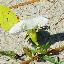

In [9]:
img = Image.open("dataset/dataset/train/class_000/00001.jpg")
print(f"Image format: {img.format}; shape: {img.size}; color scheme: {img.mode}")
img

In [10]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
        for images, labels in train_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics, total_predictions, total_labels

In [1]:
def predict(model, data_loader, criterion, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {"loss": total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics, total_predictions, total_labels

In [2]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, mas_for_train, mas_for_val, device="cuda:0", n_epochs=10, scheduler=None):
    for epoch in range(n_epochs):
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_predicted, one_epoch_labels  = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        train_dataset = torchvision.datasets.ImageFolder('./dataset/dataset/train', transform=train_transform)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers=4)
        accuracy_train = accuracy_score(one_epoch_predicted, one_epoch_labels)
        print(f"Accuracy on Train Epoch {epoch}: ", accuracy_train)
        mas_for_train.append(accuracy_train)
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device="cuda:0")
            accuracy_val = accuracy_score(predicted_labels, true_labels)
            mas_for_val.append(accuracy_val)
            print(f"Accuracy on Val Epoch {epoch}: ",accuracy_val)
        pass

### Обучение модели, запуски экспериментов

In [3]:
mas_for_train_resnet18 = []
mas_for_val_resnet18 = []
resnet18 = models.resnet18(pretrained=False)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 200)
criterion = nn.CrossEntropyLoss()
n_epochs = 20
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.01)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
scheduler = ReduceLROnPlateau(optimizer, 'min')
resnet18.to(device)

NameError: name 'models' is not defined

In [33]:
train(resnet18, train_dataloader, val_dataloader, criterion, optimizer, mas_for_train_resnet18, mas_for_val_resnet18, device, n_epochs, scheduler)

Train Epoch: 0


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 0:  0.05676
Validation Epoch: 0


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 0:  0.105
Train Epoch: 1


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 1:  0.13191
Validation Epoch: 1


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 1:  0.1516
Train Epoch: 2


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 2:  0.18752
Validation Epoch: 2


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 2:  0.2024
Train Epoch: 3


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 3:  0.22726
Validation Epoch: 3


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 3:  0.224
Train Epoch: 4


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 4:  0.25828
Validation Epoch: 4


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 4:  0.2351
Train Epoch: 5


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 5:  0.28557
Validation Epoch: 5


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 5:  0.259
Train Epoch: 6


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 6:  0.31139
Validation Epoch: 6


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 6:  0.2704
Train Epoch: 7


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 7:  0.33658
Validation Epoch: 7


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 7:  0.2803
Train Epoch: 8


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 8:  0.35752
Validation Epoch: 8


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 8:  0.2911
Train Epoch: 9


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 9:  0.37993
Validation Epoch: 9


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 9:  0.2996
Train Epoch: 10


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 10:  0.40062
Validation Epoch: 10


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 10:  0.3027
Train Epoch: 11


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 11:  0.42294
Validation Epoch: 11


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 11:  0.3173
Train Epoch: 12


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 12:  0.44431
Validation Epoch: 12


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 12:  0.3265
Train Epoch: 13


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 13:  0.46646
Validation Epoch: 13


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 13:  0.3278
Train Epoch: 14


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 14:  0.48503
Validation Epoch: 14


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 14:  0.3141
Train Epoch: 15


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 15:  0.50988
Validation Epoch: 15


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 15:  0.3346
Train Epoch: 16


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 16:  0.52872
Validation Epoch: 16


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 16:  0.3316
Train Epoch: 17


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 17:  0.54949
Validation Epoch: 17


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 17:  0.3205
Train Epoch: 18


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 18:  0.57398
Validation Epoch: 18


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 18:  0.321
Train Epoch: 19


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 19:  0.59546
Validation Epoch: 19


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 19:  0.3224


In [34]:
custom_model = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(32, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(128, 64, 3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(,8192 4096),
    nn.BatchNorm1d(4096),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048),
    nn.BatchNorm1d(2048),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 200),
)
mas_for_train_custom_model = []
mas_for_val_custom_model = []
criterion = nn.CrossEntropyLoss()
n_epochs = 20
optimizer = torch.optim.SGD(custom_model.parameters(), lr=0.01)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
scheduler = ReduceLROnPlateau(optimizer, 'min')
resnet18.to(device)
custom_model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.2, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.2, inplace=False)
  (16): Conv2d(128, 64, kernel_size=(3, 3), str

In [35]:
train(custom_model, train_dataloader, val_dataloader, criterion, optimizer, mas_for_train_custom_model, mas_for_val_custom_model, device, n_epochs, scheduler)

Train Epoch: 0


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 0:  0.05804
Validation Epoch: 0


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 0:  0.0865
Train Epoch: 1


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 1:  0.12918
Validation Epoch: 1


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 1:  0.1357
Train Epoch: 2


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 2:  0.17536
Validation Epoch: 2


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 2:  0.1743
Train Epoch: 3


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 3:  0.20694
Validation Epoch: 3


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 3:  0.2199
Train Epoch: 4


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 4:  0.22827
Validation Epoch: 4


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 4:  0.2364
Train Epoch: 5


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 5:  0.24923
Validation Epoch: 5


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 5:  0.2597
Train Epoch: 6


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 6:  0.26532
Validation Epoch: 6


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 6:  0.2899
Train Epoch: 7


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 7:  0.28275
Validation Epoch: 7


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 7:  0.295
Train Epoch: 8


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 8:  0.29731
Validation Epoch: 8


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 8:  0.3178
Train Epoch: 9


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 9:  0.30911
Validation Epoch: 9


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 9:  0.3087
Train Epoch: 10


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 10:  0.32333
Validation Epoch: 10


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 10:  0.3472
Train Epoch: 11


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 11:  0.33269
Validation Epoch: 11


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 11:  0.3538
Train Epoch: 12


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 12:  0.34193
Validation Epoch: 12


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 12:  0.3615
Train Epoch: 13


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 13:  0.35349
Validation Epoch: 13


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 13:  0.3675
Train Epoch: 14


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 14:  0.36193
Validation Epoch: 14


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 14:  0.3604
Train Epoch: 15


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 15:  0.37057
Validation Epoch: 15


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 15:  0.3802
Train Epoch: 16


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 16:  0.37801
Validation Epoch: 16


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 16:  0.3794
Train Epoch: 17


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 17:  0.38584
Validation Epoch: 17


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 17:  0.3782
Train Epoch: 18


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 18:  0.39388
Validation Epoch: 18


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 18:  0.3917
Train Epoch: 19


  0%|          | 0/3125 [00:00<?, ?it/s]

Accuracy on Train Epoch 19:  0.3998
Validation Epoch: 19


  0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on Val Epoch 19:  0.3894


In [26]:
all_losses, predicted_labels, true_labels = predict(resnet18, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Точност для resnet18 {accuracy}")

  0%|          | 0/313 [00:00<?, ?it/s]

Точност для resnet18 0.5241


In [27]:
all_losses, predicted_labels, true_labels = predict(custom_model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Точност для custom_model {accuracy}")

  0%|          | 0/313 [00:00<?, ?it/s]

Точност для custom_model 0.4163


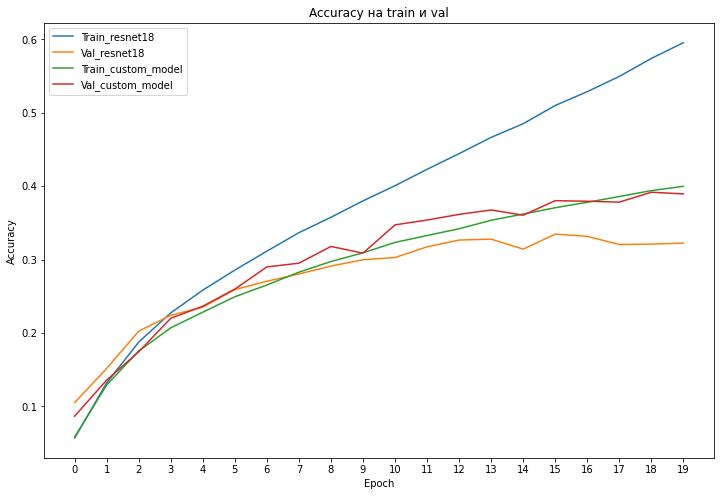

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Accuracy на train и val')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.plot(mas_for_train_resnet18, label = 'Train_resnet18')
ax.plot(mas_for_val_resnet18, label = 'Val_resnet18')
ax.plot(mas_for_train_custom_model, label = 'Train_custom_model')
ax.plot(mas_for_val_custom_model, label = 'Val_custom_model')
ax.set_xticks(np.arange(0, 20, step=1))
ax.legend()
plt.show()

In [37]:
PATH = 'C:\\Users\\Dmitry\\Desktop\\CNN\\resnet18_net.pth'
torch.save(resnet18.state_dict(), PATH)
PATH = 'C:\\Users\\Dmitry\\Desktop\\CNN\\custom_model_net.pth'
torch.save(custom_model.state_dict(), PATH)